# Datasets

In [34]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchmetrics.classification import Accuracy

import matplotlib.pyplot as plt

### Dataset Downloading

In [36]:
# Define transformation (convert to tensor and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./Datasets', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./Datasets', train=False, download=True, transform=transform)

shape của sample đầu tiên: torch.Size([1, 28, 28])
nhãn của sample đầu tiên: 0


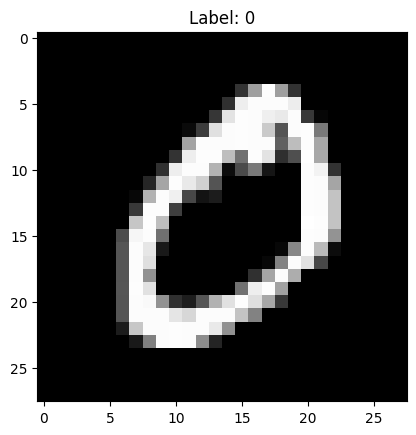

In [37]:
print(f"shape của sample đầu tiên: {train_dataset[1][0].shape}")
print(f"nhãn của sample đầu tiên: {train_dataset[1][1]}")

plt.imshow(train_dataset[1][0].squeeze(), cmap="gray")
plt.title(f"Label: {train_dataset[1][1]}")
plt.show()

### Prepare DataLoader

In [38]:
Batch_size = 64

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=False)

# Get a batch of training data
images, labels = next(iter(train_loader))

print("Image batch shape:", images.shape)   # torch.Size([64, 1, 28, 28])
print("Label batch shape:", labels.shape)   # torch.Size([64])

Image batch shape: torch.Size([64, 1, 28, 28])
Label batch shape: torch.Size([64])


# Model

In [39]:
class SoftmaxRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = self.flatten(x)
        return self.linear(x)

In [42]:
# Initialize the model
model = SoftmaxRegression()
print(model)

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

SoftmaxRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [ ]:
from torchmetrics.classification import Accuracy
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Metrics
train_accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)
test_accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)

num_epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_accuracy_metric.reset()

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        logits = model(X)
        loss = loss_fn(logits, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_accuracy_metric.update(logits, y)

    train_loss /= len(train_loader)
    train_acc = train_accuracy_metric.compute().item()
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    test_loss = 0
    test_accuracy_metric.reset()

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            test_loss += loss.item()

            test_accuracy_metric.update(logits, y)

    test_loss /= len(test_loader)
    test_acc = test_accuracy_metric.compute().item()
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1/10, Train Loss: 0.6086, Train Acc: 0.8453, Test Loss: 0.3947, Test Acc: 0.8940
Epoch 2/10, Train Loss: 0.3864, Train Acc: 0.8934, Test Loss: 0.3480, Test Acc: 0.9017
Epoch 3/10, Train Loss: 0.3522, Train Acc: 0.9009, Test Loss: 0.3247, Test Acc: 0.9084
Epoch 4/10, Train Loss: 0.3352, Train Acc: 0.9053, Test Loss: 0.3218, Test Acc: 0.9112
Epoch 5/10, Train Loss: 0.3239, Train Acc: 0.9084, Test Loss: 0.3126, Test Acc: 0.9124
Epoch 6/10, Train Loss: 0.3161, Train Acc: 0.9100, Test Loss: 0.2995, Test Acc: 0.9152
Epoch 7/10, Train Loss: 0.3099, Train Acc: 0.9121, Test Loss: 0.2983, Test Acc: 0.9151
Epoch 8/10, Train Loss: 0.3048, Train Acc: 0.9136, Test Loss: 0.2953, Test Acc: 0.9166
Epoch 9/10, Train Loss: 0.3013, Train Acc: 0.9143, Test Loss: 0.2909, Test Acc: 0.9188
Epoch 10/10, Train Loss: 0.2979, Train Acc: 0.9158, Test Loss: 0.2901, Test Acc: 0.9174


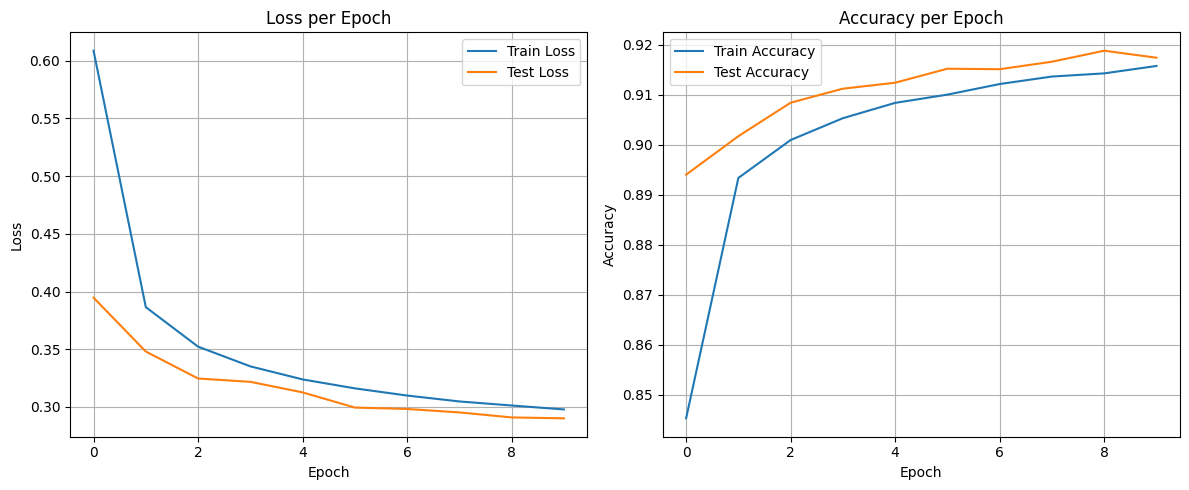

In [44]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.grid(True)

plt.tight_layout()
plt.show()


# PLot weight matrix

torch.Size([10, 784])


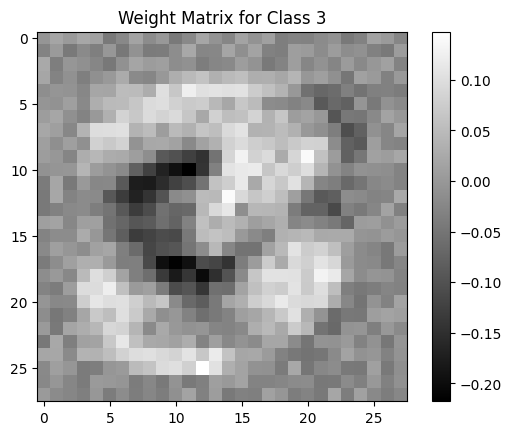

In [56]:
import matplotlib.pyplot as plt

# Get the weight matrix from the linear layer
weights = model.linear.weight.data  # shape: [10, 784]
print(weights.shape)

Class = 3 # Class index for which we want to visualize the weights
# Select the weight vector for class 0 and reshape it to 28x28
class_weights = weights[Class].reshape(28, 28)

# Plot it
plt.imshow(class_weights.cpu(), cmap='gray')  # or 'gray', 'plasma', etc.
plt.title(f"Weight Matrix for Class {Class}")
plt.colorbar()
plt.show()
